# Comparing journey times returned by Mapzen's OSRM and Valhalla instances

In [45]:
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 12)
mpl.rcParams['savefig.dpi'] = 200

The journey times were retrieved by calling Mapzen's OSRM and Valhalla instances, respectively.  
Calls to OSRM used `viaroute=bicycle`, calls to Valhalla used `{costing: bicycle}`  
No costing options were set for Valhalla.  

The journey times were retrieved from `['route_summary']['total_time']` for OSRM  
The journey times were retrieved from `['trip']['summary']['time']` for Valhalla

In [11]:
osrm_station_data = pd.read_csv('stations_travel_time.csv', index_col=0)
valhalla_station_data = pd.read_csv('stations_travel_time_valhalla.csv', index_col=0)

####Journey origin is:

-0.12203999999842599, 51.500829999995766 (lon, lat)  
27054.81221603953, 25108.754540393566 (projected coordinates)  

`centroid_distance` is calculated using pythagoras' theorem  
`travel_time` is calculated in minutes (returned journey time / 60)

In [4]:
osrm_station_data.head()

,lat,lon,name,projected_lon,projected_lat,centroid_distance,travel_time
0,51.529163,-0.109971,"River Street , Clerkenwell",27811.388447,28282.270369,2968.313250,21.654045
1,51.499607,-0.197574,"Phillimore Gardens, Kensington",21813.727944,24840.827966,3969.751444,32.328405
2,51.521284,-0.084606,"Christopher Street, Liverpool Street",29594.342661,27451.475186,4503.092527,22.447410
3,51.530059,-0.120974,"St. Chad's Street, King's Cross",27045.344113,28362.269051,2336.626317,23.625436
4,51.493130,-0.156876,"Sedding Street, Sloane Square",24657.683764,24190.679446,2899.434664,14.609929


In [13]:
merged = pd.merge(
    osrm_station_data,
    valhalla_station_data[['name', 'travel_time']],
    how='left',
    on=['name'],
    suffixes=['_osrm', '_valhalla'])

merged['duration_difference'] = merged['travel_time_osrm'] - merged['travel_time_valhalla']

In [30]:
merged.head()

,lat,lon,name,projected_lon,projected_lat,centroid_distance,travel_time_osrm,travel_time_valhalla,duration_difference
0,51.529163,-0.109971,"River Street , Clerkenwell",27811.388447,28282.270369,2968.313250,21.654045,17.133333,4.520712
1,51.499607,-0.197574,"Phillimore Gardens, Kensington",21813.727944,24840.827966,3969.751444,32.328405,17.333333,14.995072
2,51.521284,-0.084606,"Christopher Street, Liverpool Street",29594.342661,27451.475186,4503.092527,22.447410,19.300000,3.147410
3,51.530059,-0.120974,"St. Chad's Street, King's Cross",27045.344113,28362.269051,2336.626317,23.625436,16.233333,7.392102
4,51.493130,-0.156876,"Sedding Street, Sloane Square",24657.683764,24190.679446,2899.434664,14.609929,10.950000,3.659929


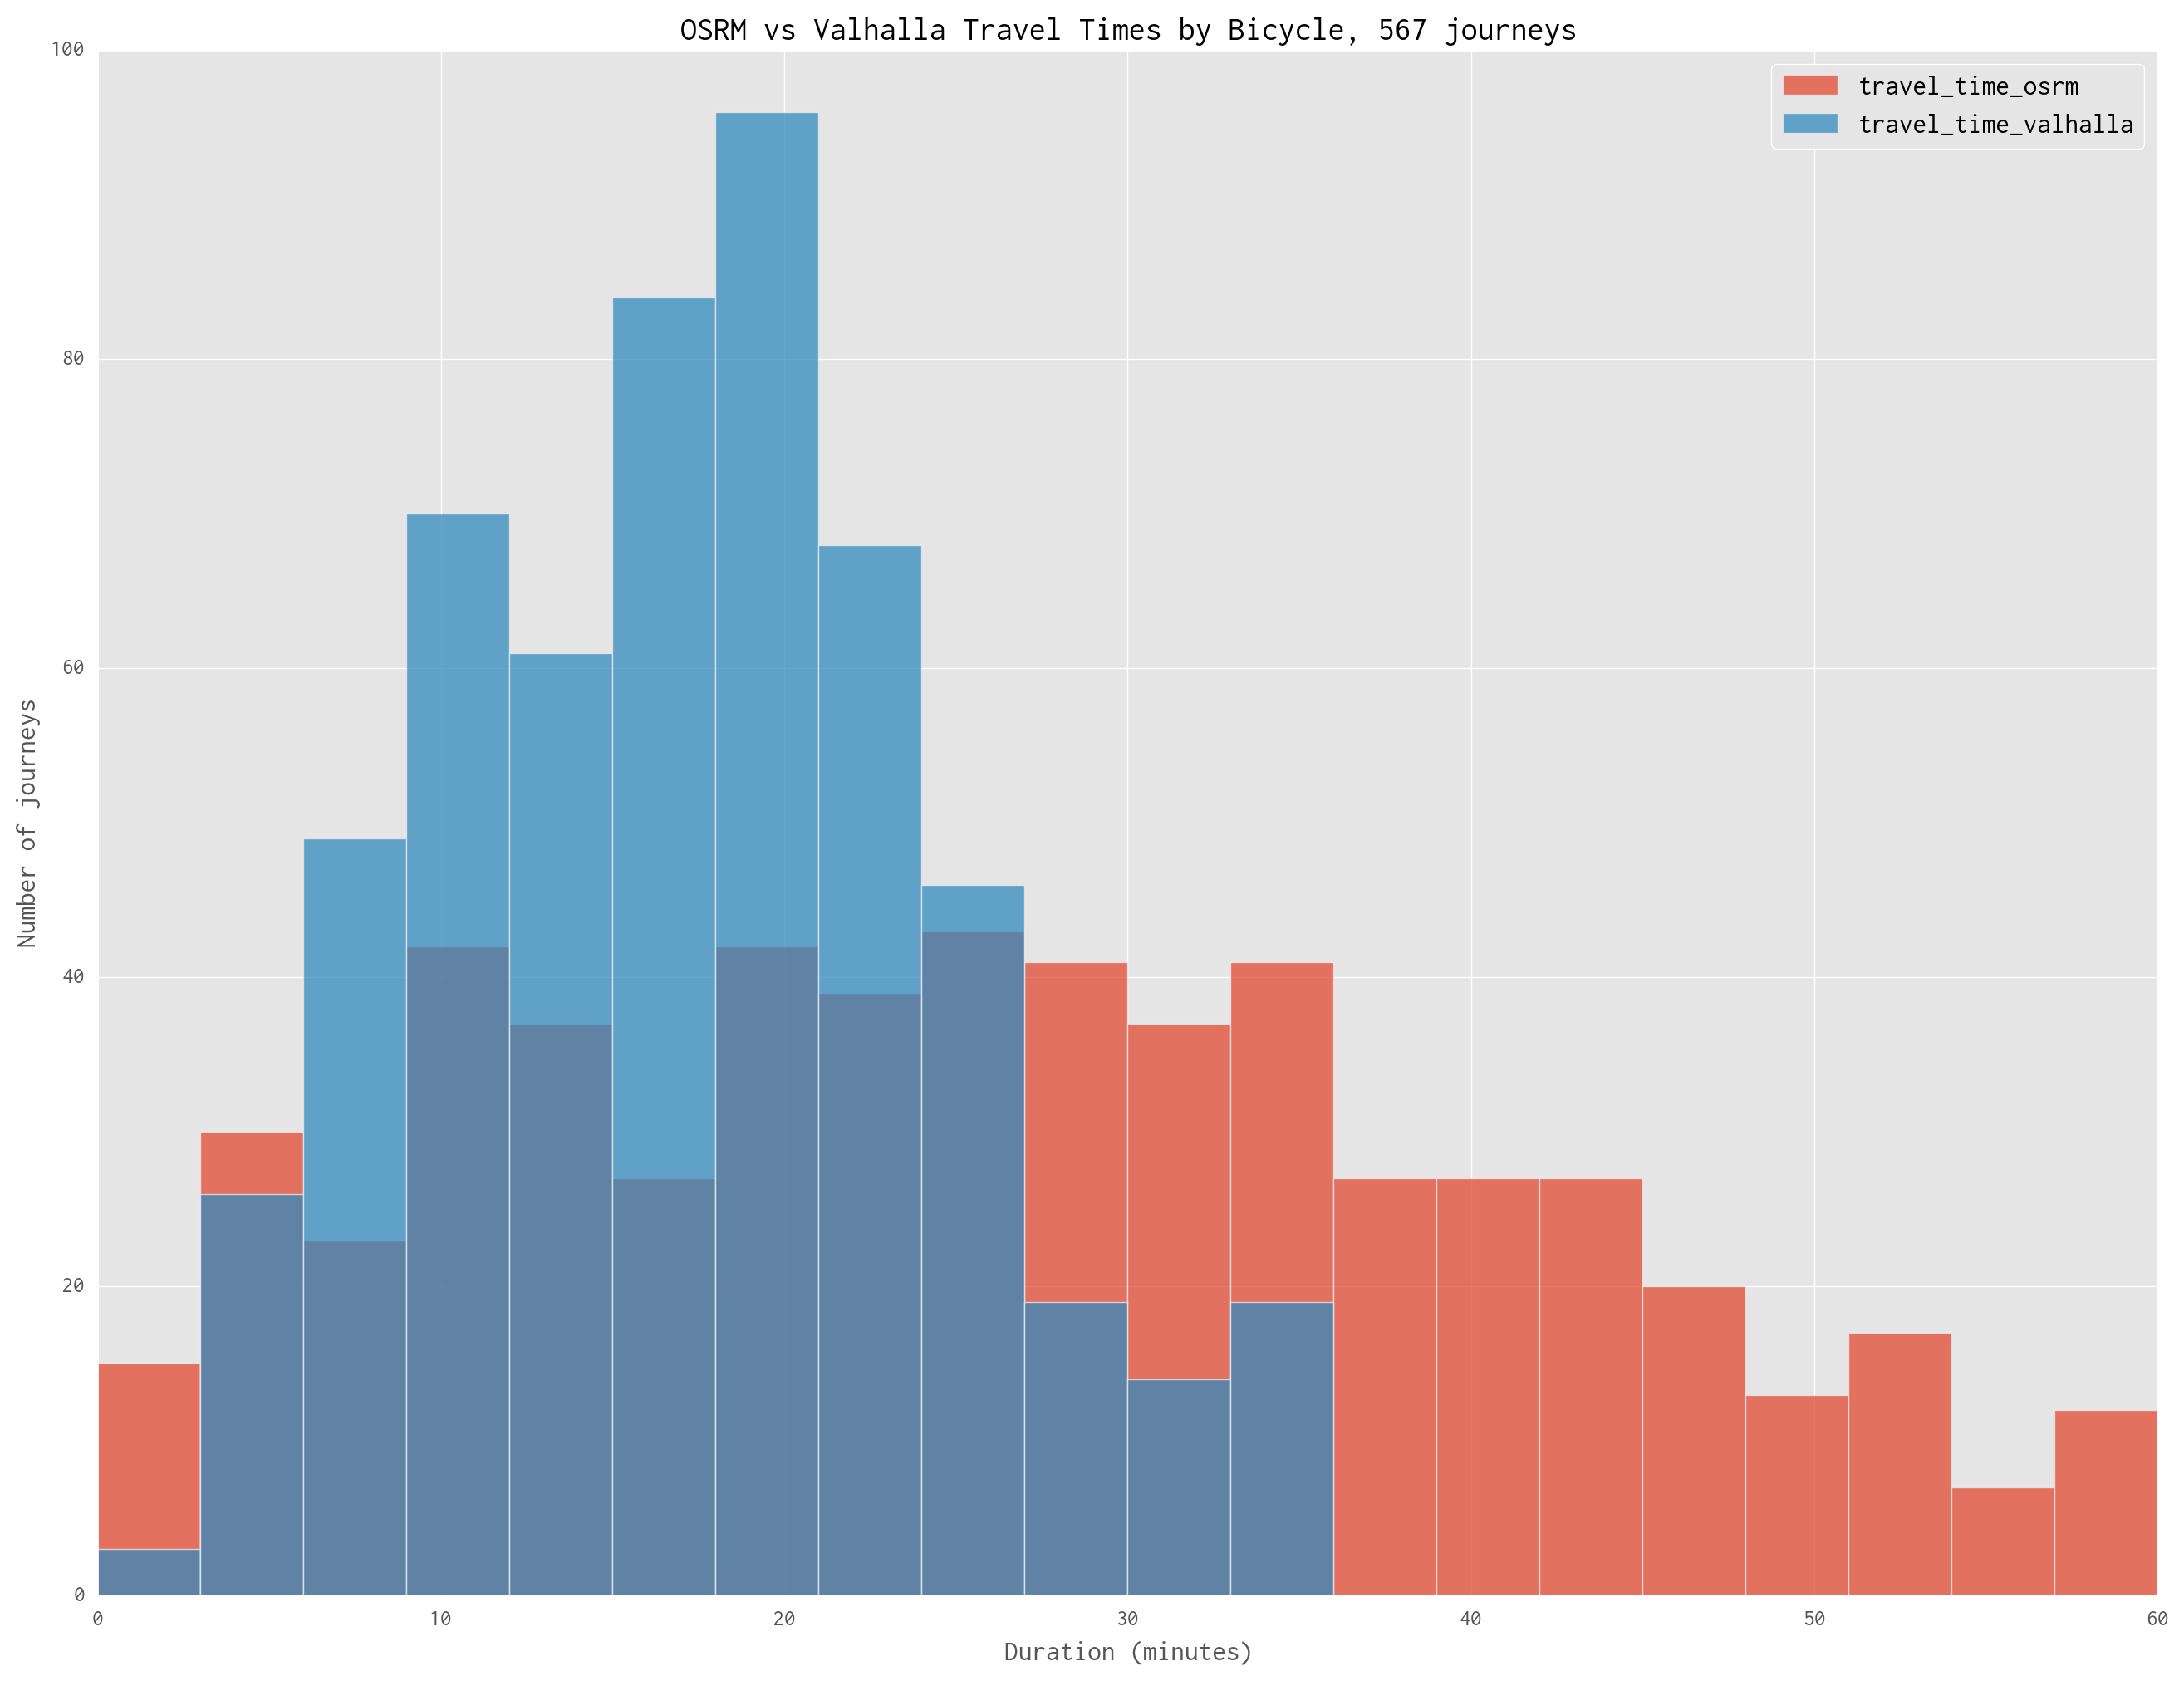

In [50]:
plt.clf()
fig = plt.figure()

ax = merged[['travel_time_osrm', 'travel_time_valhalla']].plot(
    title='OSRM vs Valhalla Travel Times by Bicycle, %s journeys' % len(merged),
    kind='hist',
    bins=20,
    alpha=0.75)

ax.set_xlabel('Duration (minutes)')
ax.set_ylabel('Number of journeys')

plt.savefig(
    "data/journey_time_difference.png",
    format="png",
    bbox_inches='tight',
    transparent=True,
    alpha=True, dpi=200)

plt.show()